# Estudio de los datos de Ventas de una Ferretería

Autor: Diana Chacón Ocariz

## Contexto:

Se trata de una pequeña ferretería que maneja un poco más de 3.000 productos distintos. Poseen un software de gestión genérico que les provee una gran cantidad de reportes, básicamente tablas con números, díficiles de analizar (un reporte puede constar de varias decenas de páginas).


## Objetivos del negocio:

**Tener más visibilidad sobre las ventas para poder mejorar el proceso de compras y la toma de decisiones en general:** 

    - Poder analizar objetivamente las ventas
    - Determinar los productos que podrían entrar en rotura de stock al final de un período
    - Identificar los productos menos vendidos
    - Identificar patrones en el comportamiento de las ventas para poder hacer predicciones de ventas
    

## Objetivos académicos:

    - Estudiar un caso real, con datos reales y cuyo resultado pueda ayudar a alguien a resolver un problema 
    - Demostrar que la ciencia de datos también puede ayudar a las PYMES
    - Conocer y practicar el uso de herramientas de ciencia de datos
    
## Fuentes de datos:

Los datos provienen de reportes sacados del software de gestión de la empresa. Se trata de archivos .xls que contienen sólo los datos de reportes sobre ventas por producto (2021 y 2022) y el stock al final del período. También se utiliza el histórico de la tasa de cambio del dólar para hacer el análisis en base a montos en esta moneda y paliar los problemas de inflación.

# Notebook 1: Carga y Limpieza de Datos

Una vez leídos los datos y luego de una primera limpieza de los DF, los guardaremos en archivos **.parquet** que serán utilizados más tarde en el **EDA**.

También los guardaremos en archivos **.xlsx** que se utilizarán en la creación de reportes en Google Data Studio para failicitar el análisis por parte de los gerentes de la ferretería.

In [1]:
# Librerías utilizadas

import os
import glob
from pathlib import Path

import pandas as pd

In [2]:
BASE_DIR = Path.cwd()
BASE_DIR

PosixPath('/home/diana/Documentos/Ciencia de Datos/Proyecto Ventas')

In [3]:
# Lectura de los archivos y creación de un DF con todos los datos
    
def read_files(FILES, col, long):

    df = pd.DataFrame()

    for filename in glob.glob(f"{BASE_DIR / FILES}"):
        df_aux = pd.read_excel(filename)
        
        info_file = Path(filename).name[:long]
        df_aux[col] = info_file

        df = pd.concat([df, df_aux])

    return df

# Carga y limpieza de datos de las Ventas de histórico (2020)

Tenemos 2 tipos de archivos: NE y FA. Los 2 tienen formato diferente (n° de columnas), pero conservaremos de los 2 la información común.

### Archivos histórico NE

Los datos están agrupados por fecha y contienen un total: Eliminaremos las líneas de encabezado y de totales.Por eso existe un desplazamiento entre el encabezado de las columnas y la verdadera información que poseen.

**Metadatos:**

**Número:** Número de la factura (conservamos como num)      
**Cliente:** Código cliente (conservamos como cliente)   
**Vendedor:** Nombre del cliente (no conservamos)      
**Nº Control:** Código del Vendedor (conservamos como vendedor)     
**Venc.:** Código de control (no conservamos)     
**Neto:** Fecha de emisión, fecha de la venta (conservamos como fecha_comp: fecha completa)
**Unnamed:** Neto o total de la venta (conservamos como monto)

In [4]:
FILES_NE_HIST = 'datos/in/ne_hist*.xls'
FILES_NE_HIST

'datos/in/ne_hist*.xls'

In [5]:
[Path(filename).name for filename in glob.glob(f"{BASE_DIR / FILES_NE_HIST}")]

['ne_hist_2020.xls']

In [6]:
%%time

df_ne_hist = read_files(FILES_NE_HIST, 'tipo', 2)

df_ne_hist

CPU times: user 213 ms, sys: 7.87 ms, total: 221 ms
Wall time: 231 ms


,Número,Cliente,Vendedor,Nº Control,Venc.,Neto,Unnamed: 6,tipo
0,07/01/2020,NaN,NaN,NaN,NaN,NaT,NaN,ne
1,0000000001,1.376379e+07,MARIELVY ZAMBRANO RANGEL,1.0,07012019,2020-01-07 11:04:00,170601.2,ne
2,Total del Día:,1.706012e+05,NaN,NaN,NaN,NaT,NaN,ne
3,31/01/2020,NaN,NaN,NaN,NaN,NaT,NaN,ne
4,0000000003,1.458927e+07,LUIS LA CRUZ,11.0,00-0013,2020-01-31 14:57:00,1661120.0,ne
...,...,...,...,...,...,...,...,...
4809,0000004510,2.313109e+07,ERIKA ZAMBRANO,7.0,A-311220,2020-12-31 11:43:00,1500000.0,ne
4810,0000004511,1.809661e+07,LUIS QUINTINI PEREZ,7.0,A-311220,2020-12-31 11:46:00,8450000.0,ne
4811,0000004512,1.842010e+07,JOSE LUIS PULIDO,14.0,31122020,2020-12-31 12:04:00,5700000.0,ne
4812,Total del Día:,1.732875e+08,NaN,NaN,NaN,NaT,NaN,ne


In [7]:
df_ne_hist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4814 entries, 0 to 4813
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Número      4814 non-null   object        
 1   Cliente     4650 non-null   float64       
 2   Vendedor    4485 non-null   object        
 3   Nº Control  4485 non-null   float64       
 4   Venc.       4485 non-null   object        
 5    Neto       4485 non-null   datetime64[ns]
 6   Unnamed: 6  4485 non-null   float64       
 7   tipo        4814 non-null   object        
dtypes: datetime64[ns](1), float64(3), object(4)
memory usage: 301.0+ KB


In [8]:
# Buscamos las filas con valores NaN 
# Corresponden a los encabezados de las ventas del día
# y los totales
df_ne_hist[ df_ne_hist.isnull().values ]

,Número,Cliente,Vendedor,Nº Control,Venc.,Neto,Unnamed: 6,tipo
0,07/01/2020,NaN,NaN,NaN,NaN,NaT,NaN,ne
0,07/01/2020,NaN,NaN,NaN,NaN,NaT,NaN,ne
0,07/01/2020,NaN,NaN,NaN,NaN,NaT,NaN,ne
0,07/01/2020,NaN,NaN,NaN,NaN,NaT,NaN,ne
0,07/01/2020,NaN,NaN,NaN,NaN,NaT,NaN,ne
...,...,...,...,...,...,...,...,...
4813,Totales:,3.187222e+10,NaN,NaN,NaN,NaT,NaN,ne
4813,Totales:,3.187222e+10,NaN,NaN,NaN,NaT,NaN,ne
4813,Totales:,3.187222e+10,NaN,NaN,NaN,NaT,NaN,ne
4813,Totales:,3.187222e+10,NaN,NaN,NaN,NaT,NaN,ne


In [9]:
# Eliminamos los registros que contienen NaN ya que corresponden a 
df_ne_hist.dropna(inplace=True)
df_ne_hist

,Número,Cliente,Vendedor,Nº Control,Venc.,Neto,Unnamed: 6,tipo
1,0000000001,13763788.0,MARIELVY ZAMBRANO RANGEL,1.0,07012019,2020-01-07 11:04:00,170601.2,ne
4,0000000003,14589274.0,LUIS LA CRUZ,11.0,00-0013,2020-01-31 14:57:00,1661120.0,ne
7,0000000004,24777484.0,LUIS YVAN ZAMBRANO,1.0,05022020,2020-02-05 11:10:00,3365523.6,ne
10,0000000005,2140356.0,AGRICOLA EL DIAMANTE DE LA FRIA CA,1.0,28022020,2020-02-28 14:57:00,150000000.0,ne
13,0000000006,13763788.0,MARIELVY ZAMBRANO RANGEL,1.0,06032020,2020-03-06 13:56:00,1045740.0,ne
...,...,...,...,...,...,...,...,...
4807,0000004508,5346084.0,VICKY MONCADA,7.0,A-311220,2020-12-31 11:11:00,12500000.0,ne
4808,0000004509,27709518.0,JOSE VERA,7.0,A-311220,2020-12-31 11:43:00,4112500.0,ne
4809,0000004510,23131088.0,ERIKA ZAMBRANO,7.0,A-311220,2020-12-31 11:43:00,1500000.0,ne
4810,0000004511,18096611.0,LUIS QUINTINI PEREZ,7.0,A-311220,2020-12-31 11:46:00,8450000.0,ne


In [10]:
# Cambio del nombre de las columnas
df_ne_hist.columns

Index(['Número', 'Cliente', 'Vendedor', 'Nº Control', 'Venc.', ' Neto',
       'Unnamed: 6', 'tipo'],
      dtype='object')

In [11]:
cols = ['num', 
        'cliente',
        'nombre',
        'vendedor',
        'control',
        'fecha_comp',
        'monto',
        'tipo']

In [12]:
df_ne_hist.columns = cols
df_ne_hist

,num,cliente,nombre,vendedor,control,fecha_comp,monto,tipo
1,0000000001,13763788.0,MARIELVY ZAMBRANO RANGEL,1.0,07012019,2020-01-07 11:04:00,170601.2,ne
4,0000000003,14589274.0,LUIS LA CRUZ,11.0,00-0013,2020-01-31 14:57:00,1661120.0,ne
7,0000000004,24777484.0,LUIS YVAN ZAMBRANO,1.0,05022020,2020-02-05 11:10:00,3365523.6,ne
10,0000000005,2140356.0,AGRICOLA EL DIAMANTE DE LA FRIA CA,1.0,28022020,2020-02-28 14:57:00,150000000.0,ne
13,0000000006,13763788.0,MARIELVY ZAMBRANO RANGEL,1.0,06032020,2020-03-06 13:56:00,1045740.0,ne
...,...,...,...,...,...,...,...,...
4807,0000004508,5346084.0,VICKY MONCADA,7.0,A-311220,2020-12-31 11:11:00,12500000.0,ne
4808,0000004509,27709518.0,JOSE VERA,7.0,A-311220,2020-12-31 11:43:00,4112500.0,ne
4809,0000004510,23131088.0,ERIKA ZAMBRANO,7.0,A-311220,2020-12-31 11:43:00,1500000.0,ne
4810,0000004511,18096611.0,LUIS QUINTINI PEREZ,7.0,A-311220,2020-12-31 11:46:00,8450000.0,ne


In [13]:
df_ne_hist = df_ne_hist.loc[:,['num', 'fecha_comp', 'cliente', 'vendedor', 'monto', 'tipo']]
df_ne_hist

,num,fecha_comp,cliente,vendedor,monto,tipo
1,0000000001,2020-01-07 11:04:00,13763788.0,1.0,170601.2,ne
4,0000000003,2020-01-31 14:57:00,14589274.0,11.0,1661120.0,ne
7,0000000004,2020-02-05 11:10:00,24777484.0,1.0,3365523.6,ne
10,0000000005,2020-02-28 14:57:00,2140356.0,1.0,150000000.0,ne
13,0000000006,2020-03-06 13:56:00,13763788.0,1.0,1045740.0,ne
...,...,...,...,...,...,...
4807,0000004508,2020-12-31 11:11:00,5346084.0,7.0,12500000.0,ne
4808,0000004509,2020-12-31 11:43:00,27709518.0,7.0,4112500.0,ne
4809,0000004510,2020-12-31 11:43:00,23131088.0,7.0,1500000.0,ne
4810,0000004511,2020-12-31 11:46:00,18096611.0,7.0,8450000.0,ne


In [14]:
df_ne_hist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4485 entries, 1 to 4811
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   num         4485 non-null   object        
 1   fecha_comp  4485 non-null   datetime64[ns]
 2   cliente     4485 non-null   float64       
 3   vendedor    4485 non-null   float64       
 4   monto       4485 non-null   float64       
 5   tipo        4485 non-null   object        
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 245.3+ KB


### Archivos histórico FA

Existe un desplazamiento entre el encabezado de las columnas y la verdadera información que poseen.

**Metadatos:**

**Número:** Número de la factura (conservamos como num)  
**Emisión:** Fecha de emisión, fecha de la venta (conservamos como fecha_comp: fecha completa)
**Venc.:** Fecha de vencimiento (no conservamos)
**Cliente:** Código cliente (conservamos como cliente)   
**Vendedor:** Nombre del cliente (no conservamos)     
**Monto Base:** Código del Vendedor (conservamos como vendedor)
**I.V.A.:** Monto base (no conservamos)  
**Otros:** IVA (no conservamos)
**Neto:** Otras cargas (no conservamos)
**Saldo:** Neto o total de la venta (conservamos como monto)
**Unnamed:** Saldo (no conservamos)

Eliminamos las líneas correspondientes a los totales del reporte.

In [15]:
FILES_FA_HIST = 'datos/in/fa_hist*.xls'
FILES_FA_HIST

'datos/in/fa_hist*.xls'

In [16]:
[Path(filename).name for filename in glob.glob(f"{BASE_DIR / FILES_FA_HIST}")]

['fa_hist_2020.xls']

In [17]:
%%time

df_fa_hist = read_files(FILES_FA_HIST, 'tipo', 2)

df_fa_hist

CPU times: user 412 ms, sys: 967 µs, total: 413 ms
Wall time: 421 ms


,Número,Emisión,Venc.,Cliente,Vendedor,Monto Base,I.V.A.,Otros,Neto,Saldo,Unnamed: 10,tipo
0,0000000001,2020-01-06 14:06:00,2020-01-06 14:06:00,14790433,MENA YOEL,3.000000e+00,2077140,0.000000e+00,0,2.077140e+06,0.0,fa
1,0000000002,2020-01-06 14:38:00,2020-01-06 14:38:00,18420417,JAVIER PEREZ,7.000000e+00,174720,0.000000e+00,0,1.747200e+05,0.0,fa
2,0000000003,2020-01-06 14:47:00,2020-01-06 14:47:00,9337863,JOSE CARDENAS,7.000000e+00,101051.03,1.212612e+04,0,1.131771e+05,0.0,fa
3,0000000004,2020-01-06 14:35:00,2020-01-06 14:35:00,9335844,THAIREE SALAS,1.100000e+01,1465.66,1.758800e+02,0,1.641540e+03,0.0,fa
4,0000000005,2020-01-06 13:58:00,2020-01-06 13:58:00,20716730,JHOJANDER RAMIREZ,1.100000e+01,34751.03,5.172000e+01,0,3.480275e+04,0.0,fa
...,...,...,...,...,...,...,...,...,...,...,...,...
6505,0000006531,2020-12-30 09:12:00,2020-12-30 09:12:00,308242187,CARALCAMPO C.A,7.000000e+00,2500000,4.000000e+05,0,2.900000e+06,0.0,fa
6506,0000006532,2020-12-30 10:48:00,2020-12-30 10:48:00,13763788,MARIELVY ZAMBRANO RANGEL,1.000000e+00,1112500,1.780000e+05,0,1.290500e+06,1290500.0,fa
6507,0000006533,2020-12-30 14:59:00,2021-01-09 14:59:00,13306599,HUGO RANGEL,7.000000e+00,9275000,1.484000e+06,0,1.075900e+07,0.0,fa
6508,0000006534,2020-12-31 10:03:00,2020-12-31 10:03:00,26015376,DAVID MENDEZ,1.400000e+01,450000,7.200000e+04,0,5.220000e+05,0.0,fa


In [18]:
df_fa_hist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6510 entries, 0 to 6509
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Número       6510 non-null   object 
 1   Emisión      6510 non-null   object 
 2   Venc.        6510 non-null   object 
 3   Cliente      6510 non-null   int64  
 4   Vendedor     6510 non-null   object 
 5   Monto Base   6510 non-null   float64
 6   I.V.A.       6510 non-null   object 
 7   Otros        6510 non-null   float64
 8   Neto         6510 non-null   object 
 9   Saldo        6510 non-null   float64
 10  Unnamed: 10  6509 non-null   float64
 11  tipo         6510 non-null   object 
dtypes: float64(4), int64(1), object(7)
memory usage: 610.4+ KB


In [19]:
# Buscamos las filas con valores NaN 
# Corresponden a los totales del reporte
df_fa_hist[ df_fa_hist.isnull().values ]

,Número,Emisión,Venc.,Cliente,Vendedor,Monto Base,I.V.A.,Otros,Neto,Saldo,Unnamed: 10,tipo
6509,Totales:,20276869997.040001,1465210270.24,0,21742780267.279999,1.532014e+09,Total de ventas a contado:,2.021077e+10,Total de ventas a credito:,1.532014e+09,NaN,fa


In [20]:
# Eliminamos los registros que contienen NaN ya que corresponden a 
# líneas de totales de los reportes 
df_fa_hist.dropna(inplace=True)
df_fa_hist

,Número,Emisión,Venc.,Cliente,Vendedor,Monto Base,I.V.A.,Otros,Neto,Saldo,Unnamed: 10,tipo
0,0000000001,2020-01-06 14:06:00,2020-01-06 14:06:00,14790433,MENA YOEL,3.0,2077140,0.00,0,2.077140e+06,0.0,fa
1,0000000002,2020-01-06 14:38:00,2020-01-06 14:38:00,18420417,JAVIER PEREZ,7.0,174720,0.00,0,1.747200e+05,0.0,fa
2,0000000003,2020-01-06 14:47:00,2020-01-06 14:47:00,9337863,JOSE CARDENAS,7.0,101051.03,12126.12,0,1.131771e+05,0.0,fa
3,0000000004,2020-01-06 14:35:00,2020-01-06 14:35:00,9335844,THAIREE SALAS,11.0,1465.66,175.88,0,1.641540e+03,0.0,fa
4,0000000005,2020-01-06 13:58:00,2020-01-06 13:58:00,20716730,JHOJANDER RAMIREZ,11.0,34751.03,51.72,0,3.480275e+04,0.0,fa
...,...,...,...,...,...,...,...,...,...,...,...,...
6504,0000006530,2020-12-29 17:15:00,2020-12-29 17:15:00,400195861,"MESA TECNICA DE AGUA ""SECTOR LOS LLANOS ALDEA ...",7.0,112425000,13028000.00,0,1.254530e+08,0.0,fa
6505,0000006531,2020-12-30 09:12:00,2020-12-30 09:12:00,308242187,CARALCAMPO C.A,7.0,2500000,400000.00,0,2.900000e+06,0.0,fa
6506,0000006532,2020-12-30 10:48:00,2020-12-30 10:48:00,13763788,MARIELVY ZAMBRANO RANGEL,1.0,1112500,178000.00,0,1.290500e+06,1290500.0,fa
6507,0000006533,2020-12-30 14:59:00,2021-01-09 14:59:00,13306599,HUGO RANGEL,7.0,9275000,1484000.00,0,1.075900e+07,0.0,fa


In [21]:
df_fa_hist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6509 entries, 0 to 6508
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Número       6509 non-null   object 
 1   Emisión      6509 non-null   object 
 2   Venc.        6509 non-null   object 
 3   Cliente      6509 non-null   int64  
 4   Vendedor     6509 non-null   object 
 5   Monto Base   6509 non-null   float64
 6   I.V.A.       6509 non-null   object 
 7   Otros        6509 non-null   float64
 8   Neto         6509 non-null   object 
 9   Saldo        6509 non-null   float64
 10  Unnamed: 10  6509 non-null   float64
 11  tipo         6509 non-null   object 
dtypes: float64(4), int64(1), object(7)
memory usage: 661.1+ KB


In [22]:
cols = ['num', 
        'fecha_comp',
        'venc',
        'cliente',
        'nombre',
        'vendedor',
        'base',
        'iva',
        'otros',
        'monto',
        'saldo',
        'tipo']

In [23]:
df_fa_hist.columns = cols
df_fa_hist

,num,fecha_comp,venc,cliente,nombre,vendedor,base,iva,otros,monto,saldo,tipo
0,0000000001,2020-01-06 14:06:00,2020-01-06 14:06:00,14790433,MENA YOEL,3.0,2077140,0.00,0,2.077140e+06,0.0,fa
1,0000000002,2020-01-06 14:38:00,2020-01-06 14:38:00,18420417,JAVIER PEREZ,7.0,174720,0.00,0,1.747200e+05,0.0,fa
2,0000000003,2020-01-06 14:47:00,2020-01-06 14:47:00,9337863,JOSE CARDENAS,7.0,101051.03,12126.12,0,1.131771e+05,0.0,fa
3,0000000004,2020-01-06 14:35:00,2020-01-06 14:35:00,9335844,THAIREE SALAS,11.0,1465.66,175.88,0,1.641540e+03,0.0,fa
4,0000000005,2020-01-06 13:58:00,2020-01-06 13:58:00,20716730,JHOJANDER RAMIREZ,11.0,34751.03,51.72,0,3.480275e+04,0.0,fa
...,...,...,...,...,...,...,...,...,...,...,...,...
6504,0000006530,2020-12-29 17:15:00,2020-12-29 17:15:00,400195861,"MESA TECNICA DE AGUA ""SECTOR LOS LLANOS ALDEA ...",7.0,112425000,13028000.00,0,1.254530e+08,0.0,fa
6505,0000006531,2020-12-30 09:12:00,2020-12-30 09:12:00,308242187,CARALCAMPO C.A,7.0,2500000,400000.00,0,2.900000e+06,0.0,fa
6506,0000006532,2020-12-30 10:48:00,2020-12-30 10:48:00,13763788,MARIELVY ZAMBRANO RANGEL,1.0,1112500,178000.00,0,1.290500e+06,1290500.0,fa
6507,0000006533,2020-12-30 14:59:00,2021-01-09 14:59:00,13306599,HUGO RANGEL,7.0,9275000,1484000.00,0,1.075900e+07,0.0,fa


In [24]:
df_fa_hist = df_fa_hist.loc[:,['num', 'fecha_comp', 'cliente', 'vendedor', 'monto', 'tipo']]
df_fa_hist

,num,fecha_comp,cliente,vendedor,monto,tipo
0,0000000001,2020-01-06 14:06:00,14790433,3.0,2.077140e+06,fa
1,0000000002,2020-01-06 14:38:00,18420417,7.0,1.747200e+05,fa
2,0000000003,2020-01-06 14:47:00,9337863,7.0,1.131771e+05,fa
3,0000000004,2020-01-06 14:35:00,9335844,11.0,1.641540e+03,fa
4,0000000005,2020-01-06 13:58:00,20716730,11.0,3.480275e+04,fa
...,...,...,...,...,...,...
6504,0000006530,2020-12-29 17:15:00,400195861,7.0,1.254530e+08,fa
6505,0000006531,2020-12-30 09:12:00,308242187,7.0,2.900000e+06,fa
6506,0000006532,2020-12-30 10:48:00,13763788,1.0,1.290500e+06,fa
6507,0000006533,2020-12-30 14:59:00,13306599,7.0,1.075900e+07,fa


### Unimos los 2 DF 

In [25]:
df_hist = pd.concat([df_ne_hist, df_fa_hist])
df_hist

,num,fecha_comp,cliente,vendedor,monto,tipo
1,0000000001,2020-01-07 11:04:00,13763788.0,1.0,170601.2,ne
4,0000000003,2020-01-31 14:57:00,14589274.0,11.0,1661120.0,ne
7,0000000004,2020-02-05 11:10:00,24777484.0,1.0,3365523.6,ne
10,0000000005,2020-02-28 14:57:00,2140356.0,1.0,150000000.0,ne
13,0000000006,2020-03-06 13:56:00,13763788.0,1.0,1045740.0,ne
...,...,...,...,...,...,...
6504,0000006530,2020-12-29 17:15:00,400195861.0,7.0,125453000.0,fa
6505,0000006531,2020-12-30 09:12:00,308242187.0,7.0,2900000.0,fa
6506,0000006532,2020-12-30 10:48:00,13763788.0,1.0,1290500.0,fa
6507,0000006533,2020-12-30 14:59:00,13306599.0,7.0,10759000.0,fa


# Carga y limpieza de Datos de las Ventas a partir de 2021

In [26]:
FILES_VENTAS = 'datos/in/*art*.xls'
FILES_VENTAS

'datos/in/*art*.xls'

In [27]:
[Path(filename).name for filename in glob.glob(f"{BASE_DIR / FILES_VENTAS}")]

['ne_art_2022_01_31.xls',
 'fa_art_2022_01_31.xls',
 'fa_art_2021.xls',
 'ne_art_2021.xls',
 'fa_art_2022_02_15.xls']

In [28]:
%%time

df = read_files(FILES_VENTAS, 'tipo', 2)

df

CPU times: user 2.38 s, sys: 35.8 ms, total: 2.41 s
Wall time: 2.43 s


,Número,Reng,Emisión,Cliente,Vendedor,Almacén,Cantidad,Unid.,Precio Unitario,Monto Base,I.V.A.,Otros,Neto,tipo
0,00001,NaN,PEGA DE CONTACTO/PEGA ZAPATERA (90 ML) ENVASADO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ne
1,0000006016,1,2022-01-03 08:38:00,29674026.0,14.0,1.00,1.0,UNI,8.64,8.64,0.00,0.0,8.64,ne
2,0000006482,1,2022-01-12 16:15:00,18018450.0,13.0,1.00,1.0,UNI,8.82,8.82,0.00,0.0,8.82,ne
3,0000006530,2,2022-01-13 15:29:00,9331467.0,7.0,1.00,1.0,UNI,8.82,8.82,0.00,0.0,8.82,ne
4,0000006625,1,2022-01-17 08:50:00,28417150.0,7.0,1.00,1.0,UNI,8.82,8.82,0.00,0.0,8.82,ne
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651,Sub-Totales:,1,23.81,0.0,0.0,23.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fa
652,06362,NaN,"TORNILLO 1/4""*2"" HEX. NC G2",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fa
653,0000006552,1,2022-02-12 11:58:00,10747716.0,1.0,1.00,6.0,UNI,5.58,5.58,0.89,0.0,6.47,fa
654,Sub-Totales:,6,5.58,0.89,0.0,6.47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fa


In [29]:
df.describe()

,Vendedor,Almacén,Cantidad,Precio Unitario,Monto Base,I.V.A.,Otros,Neto
count,34978.000000,34978.000000,29927.000000,29927.000000,29927.000000,29927.000000,29927.000000,29927.000000
mean,7.971935,84.136489,4.536228,19.750212,27.340265,0.717282,0.000006,27.310807
std,4.615195,4715.779273,21.583295,97.610942,136.671247,7.691294,0.000751,114.588826
min,0.000000,0.010000,0.020000,0.002790,0.010000,0.000000,0.000000,0.010000
25%,7.000000,1.000000,1.000000,2.000000,2.640000,0.000000,0.000000,2.720000
50%,10.000000,1.000000,1.000000,5.630000,7.600000,0.000000,0.000000,7.800000
75%,11.000000,1.000000,3.000000,14.700000,21.000000,0.000000,0.000000,21.500000
max,14.000000,618970.850000,2000.000000,5287.500000,11340.010000,846.000000,0.120000,6133.500000


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40024 entries, 0 to 655
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Número            40024 non-null  object 
 1   Reng              35575 non-null  object 
 2   Emisión           40024 non-null  object 
 3   Cliente           34978 non-null  object 
 4   Vendedor          34978 non-null  float64
 5   Almacén           34978 non-null  float64
 6   Cantidad          29927 non-null  float64
 7   Unid.             29927 non-null  object 
 8   Precio Unitario   29927 non-null  float64
 9   Monto Base        29927 non-null  float64
 10  I.V.A.            29927 non-null  float64
 11  Otros             29927 non-null  float64
 12  Neto              29927 non-null  float64
 13  tipo              40024 non-null  object 
dtypes: float64(8), object(6)
memory usage: 4.6+ MB


## Limpieza y transformación de los datos:

Aunque los datos no tienen ningún formato especial de Excel, tienen la forma de un reporte con totales, subtotales y datos agrupados por producto

- **Eliminación de totales:** Eliminamos las lineas que continen "total" ya que son los totales y subtotales de los reportes
- **Eliminación de información no relevante:** Conservaremos solo las siguientes columnas: Número, Emisión, Cliente, Vendedor, Cantidad, Neto y Tipo 
- **Construcción del DF definitvo:** Recorreremos el DF para recuperar la información por producto y crearemos un nuevo DF con los datos definitivos
- **Cambio tipos columnas:** Cambiamos el tipo a la columna Vendedor para que sea de tipo entero. Transformamos el campo de fecha para que sea de tipo datetime. Transformamos las columnas num y cliente a str

### Eliminación de totales y subtotales

In [31]:
# Buscamos las filas de totales y subtotales para eliminarlas
df[df.Número.str.contains('Totales')] 

,Número,Reng,Emisión,Cliente,Vendedor,Almacén,Cantidad,Unid.,Precio Unitario,Monto Base,I.V.A.,Otros,Neto,tipo
5,Sub-Totales:,4,35.1,0.0,0.0,35.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ne
25,Sub-Totales:,86,498.96,0.0,0.0,498.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ne
46,Sub-Totales:,42,744.61,0.0,0.0,744.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ne
51,Sub-Totales:,4,112.2,0.0,0.0,112.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ne
57,Sub-Totales:,33,188.82,0.0,0.0,188.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ne
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645,Sub-Totales:,1,204.6,32.74,0.0,237.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fa
648,Sub-Totales:,1,139.5,0.0,0.0,139.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fa
651,Sub-Totales:,1,23.81,0.0,0.0,23.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fa
654,Sub-Totales:,6,5.58,0.89,0.0,6.47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fa


In [32]:
df_aux = df[~df.Número.str.contains('Totales')]
df_aux

,Número,Reng,Emisión,Cliente,Vendedor,Almacén,Cantidad,Unid.,Precio Unitario,Monto Base,I.V.A.,Otros,Neto,tipo
0,00001,NaN,PEGA DE CONTACTO/PEGA ZAPATERA (90 ML) ENVASADO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ne
1,0000006016,1,2022-01-03 08:38:00,29674026.0,14.0,1.0,1.0,UNI,8.6400,8.64,0.00,0.0,8.64,ne
2,0000006482,1,2022-01-12 16:15:00,18018450.0,13.0,1.0,1.0,UNI,8.8200,8.82,0.00,0.0,8.82,ne
3,0000006530,2,2022-01-13 15:29:00,9331467.0,7.0,1.0,1.0,UNI,8.8200,8.82,0.00,0.0,8.82,ne
4,0000006625,1,2022-01-17 08:50:00,28417150.0,7.0,1.0,1.0,UNI,8.8200,8.82,0.00,0.0,8.82,ne
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647,0000006523,1,2022-02-10 16:01:00,14790466.0,10.0,1.0,1.0,UNI,139.5000,139.50,0.00,0.0,139.50,fa
649,06359,NaN,CUCHILLA 1 PASE 2P 60A KS KNIFE SWITCH CAJA RO...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fa
650,0000006536,1,2022-02-12 11:03:00,30992477.0,1.0,1.0,1.0,UNI,23.8094,23.81,0.00,0.0,23.81,fa
652,06362,NaN,"TORNILLO 1/4""*2"" HEX. NC G2",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fa


### Eliminación de columnas no relevantes

In [33]:
# Cambiamos el nombre de las columnas
df_aux.columns

Index(['Número', 'Reng', 'Emisión ', 'Cliente ', 'Vendedor', 'Almacén',
       'Cantidad', 'Unid.', 'Precio Unitario ', 'Monto Base', 'I.V.A.',
       'Otros', 'Neto', 'tipo'],
      dtype='object')

In [34]:
cols = ['num', 'reng', 'fecha_comp', 'cliente', 'vendedor', 'almacen', 'cantidad',
       'und', 'precio', 'base', 'iva', 'otros', 'neto', 'tipo']
df_aux.columns = cols
df_aux.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34973 entries, 0 to 653
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   num         34973 non-null  object 
 1   reng        30524 non-null  object 
 2   fecha_comp  34973 non-null  object 
 3   cliente     29927 non-null  object 
 4   vendedor    29927 non-null  float64
 5   almacen     29927 non-null  float64
 6   cantidad    29927 non-null  float64
 7   und         29927 non-null  object 
 8   precio      29927 non-null  float64
 9   base        29927 non-null  float64
 10  iva         29927 non-null  float64
 11  otros       29927 non-null  float64
 12  neto        29927 non-null  float64
 13  tipo        34973 non-null  object 
dtypes: float64(8), object(6)
memory usage: 4.0+ MB


In [35]:
df_aux = df_aux.loc[:,['num', 'fecha_comp', 'cliente', 'vendedor', 'cantidad', 'neto', 'tipo']]
df_aux


,num,fecha_comp,cliente,vendedor,cantidad,neto,tipo
0,00001,PEGA DE CONTACTO/PEGA ZAPATERA (90 ML) ENVASADO,NaN,NaN,NaN,NaN,ne
1,0000006016,2022-01-03 08:38:00,29674026.0,14.0,1.0,8.64,ne
2,0000006482,2022-01-12 16:15:00,18018450.0,13.0,1.0,8.82,ne
3,0000006530,2022-01-13 15:29:00,9331467.0,7.0,1.0,8.82,ne
4,0000006625,2022-01-17 08:50:00,28417150.0,7.0,1.0,8.82,ne
...,...,...,...,...,...,...,...
647,0000006523,2022-02-10 16:01:00,14790466.0,10.0,1.0,139.50,fa
649,06359,CUCHILLA 1 PASE 2P 60A KS KNIFE SWITCH CAJA RO...,NaN,NaN,NaN,NaN,fa
650,0000006536,2022-02-12 11:03:00,30992477.0,1.0,1.0,23.81,fa
652,06362,"TORNILLO 1/4""*2"" HEX. NC G2",NaN,NaN,NaN,NaN,fa


### Construcción del DF definitivo

Los datos en el DF están agrupados por producto: Una línea tiene la información sobre el producto y las siguientes son las facturas que incluyen el producto. 

El objetivo es obtener un DF con la siguiente información por cada línea:

    - num: Número de factura (columna num)
    - fecha: Fecha de la factura (columna fecha)
    - cliente: Código del cliente (columna cliente)
    - vendedor: Código del vendedor (columna vendedor)
    - cod: Código del producto (columna num cuando el largo <=5 )
    - producto: Descripción del producto (columna fecha)
    - cantidad: Cantidad de producto en la factura (columna cantidad)
    - monto: Monto neto del producto en la factura (columna neto)
    - tipo: Tipo de factura (columna tipo)
    
Para eso, recorremos el DF y lo vamos construyendo.

In [36]:
%%time

result = []

cod = ''
prod = ''

for index, row in df_aux.iterrows(): 
    if len(row['num']) <= 5 :
        cod = row['num']
        prod = row['fecha_comp']
    else:
        dic = {}
        dic['num'] = row['num']
        dic['fecha_comp'] = row['fecha_comp']
        dic['cliente'] = row['cliente']
        dic['vendedor'] = row['vendedor']
        dic['cod'] = cod
        dic['producto'] = prod
        dic['cantidad'] = row['cantidad']
        dic['monto'] = row['neto']   
        dic['tipo'] = row['tipo'] 
        
        result.append(dic)


CPU times: user 3.67 s, sys: 23.9 ms, total: 3.69 s
Wall time: 3.72 s


In [37]:
df_ventas = pd.DataFrame(result)
df_ventas.sample(30)

,num,fecha_comp,cliente,vendedor,cod,producto,cantidad,monto,tipo
3723,0000004485,2021-05-17 15:24:00,21180705,11.0,00122,"RIEGO ABRAZADERA PLASTICA 32MM * 1/2"" AGRO/MOM/FP",4.0,13.56,fa
3465,0000004468,2021-05-17 09:37:00,12890460,7.0,00053,"PVC SEMI CODO 110MM/4""x3.2MM AGUAS NEGRAS INPL...",1.0,7.48,fa
4284,0000002464,2021-03-09 11:33:00,16788429,7.0,00166,RIEGO UNION RAPIDA 32MM AGRO,15.0,32.74,fa
7924,0000004173,2021-05-04 15:25:00,028133002,11.0,00805,"LLAVE CHORRO 1/2"" PLASTICA CON PICO ECONOMICA ...",1.0,6.73,fa
16400,0000005453,2021-06-22 14:04:00,18420756,11.0,05945,PEGA O COLA 500G BLANCA HERCULES,1.0,10.83,fa
25922,0000004047,2021-11-01 09:39:00,24777191.0,13.0,03551,"RIEGO ABRAZADERA PLASTICA 125MM * 1"" AGRO",1.0,29.90,ne
10512,0000001372,2021-02-05 00:00:00,310875820,13.0,01602,"RAMPLUG PLASTICO NARANJA 2""*3/8""",6.0,0.49,fa
24085,0000005658,2021-12-17 15:04:00,14281213.0,11.0,01841,"LLAVE PLASTICA 1 1/2"" ROSCADA",1.0,18.80,ne
19459,0000003743,2021-10-20 08:08:00,12890941.0,7.0,00411,"RIEGO ABRAZADERA PLASTICA 32MM * 1"" AGRO",3.0,14.25,ne
2299,0000006280,2022-01-07 11:47:00,18419719.0,13.0,04555,GRAPA Nº8 PLASTICA CON CLAVO (BOLSA 100 PZS),1.0,5.54,ne


In [38]:
df_ventas.describe()

,vendedor,cantidad,monto
count,29927.000000,29927.000000,29927.000000
mean,9.317406,4.536228,27.310807
std,3.515463,21.583295,114.588826
min,1.000000,0.020000,0.010000
25%,7.000000,1.000000,2.720000
50%,10.000000,1.000000,7.800000
75%,11.000000,3.000000,21.500000
max,14.000000,2000.000000,6133.500000


In [39]:
df_ventas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29927 entries, 0 to 29926
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   num         29927 non-null  object        
 1   fecha_comp  29927 non-null  datetime64[ns]
 2   cliente     29927 non-null  object        
 3   vendedor    29927 non-null  float64       
 4   cod         29927 non-null  object        
 5   producto    29927 non-null  object        
 6   cantidad    29927 non-null  float64       
 7   monto       29927 non-null  float64       
 8   tipo        29927 non-null  object        
dtypes: datetime64[ns](1), float64(3), object(5)
memory usage: 2.1+ MB


## Unión del Histórico con las Ventas desde 2021

Solo los registros a partir del 2021 tienen información sobre el detalle de las facturas (producto y cantidad)

In [40]:
df_ventas_totales = pd.concat([df_hist, df_ventas])
df_ventas_totales.sample(20)

,num,fecha_comp,cliente,vendedor,monto,tipo,cod,producto,cantidad
29892,0000006525,2022-02-11 09:10:00,307767995.0,13.0,64.73,fa,05218,"VALVULA 1/2"" CHECK HORIZONTAL ITALIANA",1.0
17003,0000002213,2021-08-31 14:29:00,5345779.0,11.0,15.75,ne,00008,ALAMBRE C-17.5 LISO HG KILOGRAMO VICSON,1.0
28848,0000004566,2021-11-17 11:11:00,18968364.0,14.0,6.64,ne,05339,"NIPLE PLASTICO 1"" * 5.5CMS",2.0
29778,0000006506,2022-02-08 16:28:00,310060940.0,11.0,5.52,fa,01232,"BUSINHG PLASTICO REDUCIDO 3/4"" * 1/2"" AZUL/BL...",4.0
22011,0000004710,2021-11-20 08:39:00,23159531.0,11.0,265.25,ne,00911,"PUNTO SOLDADURA PEAD DESDE 32MM A 250MM/8""",5.0
15796,0000003338,2021-04-07 11:26:00,9128247,13.0,2.04,fa,05102,COPIA DE LLAVE,1.0
504,0000000506,2020-01-17 13:57:00,15433994.0,11.0,251116.80,fa,NaN,NaN,NaN
669,0000007291,2022-01-31 12:01:00,9330813.0,14.0,7.26,ne,00415,"ANILLO HG 1/2""",6.0
5094,0000002244,2021-03-03 11:15:00,17219812,14.0,7.60,fa,00291,"ANILLO HG 1""",4.0
3145,0000002922,2020-11-11 08:26:00,12890870.0,14.0,3384479.67,ne,NaN,NaN,NaN


In [41]:
# Reemplazamos los valores NaN por 0 en la columna cantidad para los registros del hitórico
# Reemplazamos los valores NaN por "" en las columnas cod y producto del histórico

df_ventas_totales.cantidad.fillna(0, inplace=True)
df_ventas_totales.fillna('', inplace=True)
df_ventas_totales

,num,fecha_comp,cliente,vendedor,monto,tipo,cod,producto,cantidad
1,0000000001,2020-01-07 11:04:00,13763788.0,1.0,1.706012e+05,ne,,,0.0
4,0000000003,2020-01-31 14:57:00,14589274.0,11.0,1.661120e+06,ne,,,0.0
7,0000000004,2020-02-05 11:10:00,24777484.0,1.0,3.365524e+06,ne,,,0.0
10,0000000005,2020-02-28 14:57:00,2140356.0,1.0,1.500000e+08,ne,,,0.0
13,0000000006,2020-03-06 13:56:00,13763788.0,1.0,1.045740e+06,ne,,,0.0
...,...,...,...,...,...,...,...,...,...
29922,0000006504,2022-02-08 16:05:00,200007230.0,1.0,8.091000e+01,fa,06315,"TUBO PLASTICO 1/2""*6MTS AZUL SHEDULE INPLAVEN",1.0
29923,0000006489,2022-02-04 07:40:00,200007230.0,1.0,2.373400e+02,fa,06341,PINTURA CUÑETE 4G CAUCHO SUPERIOR BLANCO CLASE...,1.0
29924,0000006523,2022-02-10 16:01:00,14790466.0,10.0,1.395000e+02,fa,06348,"RIEGO ABRAZADERA METALICA 110MM""* 2"" JC",1.0
29925,0000006536,2022-02-12 11:03:00,30992477.0,1.0,2.381000e+01,fa,06359,CUCHILLA 1 PASE 2P 60A KS KNIFE SWITCH CAJA RO...,1.0


In [42]:
# Transformamos los tipos de columnas para que se guarden con el tipo correcto
# Creamos la columna fecha con solo la fecha, sin tiempo. Será utilizada más adelante

df_ventas_totales.cod = df_ventas.cod.astype(str)
df_ventas_totales.vendedor = df_ventas.vendedor.astype(int)
df_ventas_totales.cliente = df_ventas.cliente.astype(str)
df_ventas_totales.fecha_comp = pd.to_datetime(df_ventas_totales.fecha_comp)
df_ventas_totales['fecha'] = pd.to_datetime(df_ventas_totales.fecha_comp.dt.date)

df_ventas_totales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40921 entries, 1 to 29926
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   num         40921 non-null  object        
 1   fecha_comp  40921 non-null  datetime64[ns]
 2   cliente     40921 non-null  object        
 3   vendedor    40921 non-null  int64         
 4   monto       40921 non-null  float64       
 5   tipo        40921 non-null  object        
 6   cod         40921 non-null  object        
 7   producto    40921 non-null  object        
 8   cantidad    40921 non-null  float64       
 9   fecha       40921 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(1), object(5)
memory usage: 3.4+ MB


In [43]:
# Las referencias de facturas pueden repetirse
df_ventas_totales.groupby(['num', 'tipo']).count().sort_values(['num', 'cod'], ascending=False)

fecha_comp  cliente  vendedor  monto  cod  producto  \
num        tipo                                                        
0000007318 ne             2        2         2      2    2         2   
0000007317 ne             3        3         3      3    3         3   
0000007316 ne             2        2         2      2    2         2   
0000007315 ne             4        4         4      4    4         4   
0000007314 ne             1        1         1      1    1         1   
...                     ...      ...       ...    ...  ...       ...   
0000000003 fa             3        3         3      3    3         3   
0000000002 fa             5        5         5      5    5         5   
           ne             2        2         2      2    2         2   
0000000001 fa             2        2         2      2    2         2   
           ne             1        1         1      1    1         1   

                 cantidad  fecha  
num        tipo                   
0000007318 ne           2      2  
0000007317 ne           3      3  
0000007316 ne           2      2  
0000007315 ne           4      4  
0000007314 ne           1      1  
...                   ...    ...  
0000000003 fa           3      3  
0000000002 fa           5      5  
           ne           2      2  
0000000001 fa           2      2  
           ne           1      1  

[13883 rows x 8 columns]

In [44]:
df_ventas_totales.query('num == "0000000001"')  

,num,fecha_comp,cliente,vendedor,monto,tipo,cod,producto,cantidad,fecha
1,0000000001,2020-01-07 11:04:00,18018450.0,13,170601.20,ne,00001,,0.0,2020-01-07
0,0000000001,2020-01-06 14:06:00,29674026.0,14,2077140.00,fa,00001,,0.0,2020-01-06
11363,0000000001,2021-01-05 08:19:00,17220570,7,2.58,fa,02304,"LLAVE PLASTICA 1"" ROSCADA",1.0,2021-01-05


In [45]:
# Transformamos la columna num para que sea un identificador único

def columna_num(anio, num, tipo):
    anio = str(anio)[0:4]
    result = str(anio) + '-' + str(num) + '-' + str(tipo)
    return result

df_ventas_totales.num = df_ventas_totales.apply(
                        lambda row: columna_num(row.fecha, row.num, row.tipo), 
                        axis = 1)

df_ventas_totales

,num,fecha_comp,cliente,vendedor,monto,tipo,cod,producto,cantidad,fecha
1,2020-0000000001-ne,2020-01-07 11:04:00,18018450.0,13,1.706012e+05,ne,00001,,0.0,2020-01-07
4,2020-0000000003-ne,2020-01-31 14:57:00,13763886.0,7,1.661120e+06,ne,00005,,0.0,2020-01-31
7,2020-0000000004-ne,2020-02-05 11:10:00,19778448.0,14,3.365524e+06,ne,00005,,0.0,2020-02-05
10,2020-0000000005-ne,2020-02-28 14:57:00,10747486.0,7,1.500000e+08,ne,00005,,0.0,2020-02-28
13,2020-0000000006-ne,2020-03-06 13:56:00,10747339.0,7,1.045740e+06,ne,00005,,0.0,2020-03-06
...,...,...,...,...,...,...,...,...,...,...
29922,2022-0000006504-fa,2022-02-08 16:05:00,200007230.0,1,8.091000e+01,fa,06315,"TUBO PLASTICO 1/2""*6MTS AZUL SHEDULE INPLAVEN",1.0,2022-02-08
29923,2022-0000006489-fa,2022-02-04 07:40:00,200007230.0,1,2.373400e+02,fa,06341,PINTURA CUÑETE 4G CAUCHO SUPERIOR BLANCO CLASE...,1.0,2022-02-04
29924,2022-0000006523-fa,2022-02-10 16:01:00,14790466.0,10,1.395000e+02,fa,06348,"RIEGO ABRAZADERA METALICA 110MM""* 2"" JC",1.0,2022-02-10
29925,2022-0000006536-fa,2022-02-12 11:03:00,30992477.0,1,2.381000e+01,fa,06359,CUCHILLA 1 PASE 2P 60A KS KNIFE SWITCH CAJA RO...,1.0,2022-02-12


In [46]:
df_ventas_totales.sample(20)

,num,fecha_comp,cliente,vendedor,monto,tipo,cod,producto,cantidad,fecha
12908,2021-0000000818-fa,2021-01-23 08:54:00,82212826,11,5.62,fa,03497,"RIEGO ABRAZADERA PLASTICA 63MM * 1"" AGRO/FP/MOM",1.00,2021-01-23
12579,2021-0000000201-fa,2021-01-09 10:58:00,24151990,11,21.64,fa,03283,"RIEGO ABRAZADERA PLASTICA 63MM * 3/4"" AGRO",4.00,2021-01-09
3734,2020-0000003740-fa,2020-05-08 11:36:00,10748013,14,697120.00,fa,00122,,0.00,2020-05-08
6812,2021-0000005662-fa,2021-07-06 14:41:00,310060940,1,3.61,fa,00652,LIJA GRANO 280 3M,1.00,2021-07-06
9140,2021-0000000378-fa,2021-01-14 10:31:00,028134165,10,5.04,fa,01171,GRAPAS HG 1*9 TREXA/ MEJIA (POR KILOGRAMO),1.05,2021-01-14
484,2020-0000000486-fa,2020-01-16 16:46:00,12890941.0,7,687648.00,fa,00291,,0.00,2020-01-16
6044,2020-0000006054-fa,2020-07-24 11:22:00,310060940,7,180681.60,fa,00436,,0.00,2020-07-24
27627,2021-0000004365-ne,2021-11-11 11:00:00,12889398.0,10,4.36,ne,04612,BOMBILLO 60W E27 GLOBE BULB,1.00,2021-11-11
18274,2021-0000002264-ne,2021-09-02 10:25:00,18420029.0,7,5.56,ne,00212,BAILARINA PUNTO BLANCO AGRO APB,1.00,2021-09-02
18233,2021-0000004340-ne,2021-11-10 15:16:00,13762581.0,3,9.56,ne,00205,"PIE DE AMIGO 2""*2"" HG CANTO PARA MUEBLE",4.00,2021-11-10


In [47]:
df_ventas_totales[df_ventas_totales.producto.isnull()]

,num,fecha_comp,cliente,vendedor,monto,tipo,cod,producto,cantidad,fecha


## Tasa de cambio

Para mitigar los efectos de la inflación, los montos, originalmente en Bolívares (Bs), serán transformados a montos en $USD. Para eso, utilizamos un archivo CSV con todas las tasas de cambio diarias. Luego asignamos la tasa correspondiente a cada registro según la fecha.

El archivo CSV con las tasas de cambio lo creamos a partir de un [scraper](https://github.com/dchaconoca/proyecto-ventas/blob/master/scraper_tasa_dolar.ipynb)

In [48]:
FILE_DOLAR = 'datos/in/tasa_dolar.csv'

df_dolar = pd.read_csv(f"{BASE_DIR / FILE_DOLAR}", sep=';')
df_dolar

,fecha,baja,alta
0,16-02-2022,4.61,4.66
1,15-02-2022,4.59,4.64
2,14-02-2022,4.60,4.64
3,13-02-2022,4.63,4.65
4,12-02-2022,4.63,4.66
...,...,...,...
820,19-11-2019,25931.00,33034.00
821,18-11-2019,29027.00,30849.00
822,17-11-2019,28277.00,29509.00
823,16-11-2019,28430.00,29229.00


In [49]:
# Convertimos las columnas a su tipo correspondiente

df_dolar.fecha = pd.to_datetime(df_dolar.fecha, dayfirst=True)
df_dolar.alta = df_dolar.alta.astype(float)
df_dolar.baja = df_dolar.baja.astype(float)

df_dolar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   fecha   825 non-null    datetime64[ns]
 1   baja    825 non-null    float64       
 2   alta    825 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 19.5 KB


In [50]:
# Aplicamos la reconversión (eliminar 6 ceros a partir del 01-01-2021 y para montos mayores de 1000)
# Para el momento de la reconversión, el precio del $ sobrepasaba el 1.000.000 de Bs
def conversion(tasa, fecha):
    return (tasa/1000000 if tasa>1000 and pd.to_datetime(fecha)>pd.to_datetime('2020-12-31') else tasa)

df_dolar['tasa_dolar'] = df_dolar.apply(lambda row: conversion(row['baja'], row['fecha']), axis = 1)
df_dolar.sample(20)

,fecha,baja,alta,tasa_dolar
356,2021-02-25,1845147.12,1901116.16,1.845147
310,2021-04-12,2238957.06,2340656.75,2.238957
251,2021-06-10,2892663.45,3140165.14,2.892663
282,2021-05-10,2696958.67,2805115.24,2.696959
557,2020-08-08,275589.91,293039.49,275589.910000
695,2020-03-23,68034.00,75202.00,68034.000000
2,2022-02-14,4.60,4.64,4.600000
142,2021-09-27,3509485.07,4207933.03,3.509485
813,2019-11-26,35803.00,37819.00,35803.000000
243,2021-06-18,3010517.70,3137951.49,3.010518


In [51]:
df_dolar = df_dolar.loc[:, ['fecha', 'tasa_dolar']]
df_dolar

,fecha,tasa_dolar
0,2022-02-16,4.61
1,2022-02-15,4.59
2,2022-02-14,4.60
3,2022-02-13,4.63
4,2022-02-12,4.63
...,...,...
820,2019-11-19,25931.00
821,2019-11-18,29027.00
822,2019-11-17,28277.00
823,2019-11-16,28430.00


In [52]:
df_ventas_totales = pd.merge(df_ventas_totales, df_dolar, on='fecha')

df_ventas_totales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40921 entries, 0 to 40920
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   num         40921 non-null  object        
 1   fecha_comp  40921 non-null  datetime64[ns]
 2   cliente     40921 non-null  object        
 3   vendedor    40921 non-null  int64         
 4   monto       40921 non-null  float64       
 5   tipo        40921 non-null  object        
 6   cod         40921 non-null  object        
 7   producto    40921 non-null  object        
 8   cantidad    40921 non-null  float64       
 9   fecha       40921 non-null  datetime64[ns]
 10  tasa_dolar  40921 non-null  float64       
dtypes: datetime64[ns](2), float64(3), int64(1), object(5)
memory usage: 3.7+ MB


In [53]:
df_ventas_totales.sample(20)

,num,fecha_comp,cliente,vendedor,monto,tipo,cod,producto,cantidad,fecha,tasa_dolar
748,2020-0000004802-fa,2020-06-10 10:04:00,13306599,10,554074.00,fa,00233,,0.0,2020-06-10,196868.620000
13739,2022-0000006599-ne,2022-01-15 10:14:00,22678838.0,10,6.28,ne,00416,"ANILLO HG 3/4""",2.0,2022-01-15,4.900000
25023,2021-0000005473-ne,2021-12-13 15:34:00,27709212.0,14,14.40,ne,04242,"DISCO 4 1/2"" DESBASTE METAL DEWALT DW44540",2.0,2021-12-13,4.690000
33006,2021-0000000344-ne,2021-07-05 11:15:00,18968983.0,3,2.35,ne,00802,"TEIPE ELECTRICO 3/4""*10MTS NEGRO COBRA ORIGINAL",1.0,2021-07-05,3.096650
5228,2020-0000003084-ne,2020-11-17 14:37:00,21637107,3,1111080.00,ne,00017,,0.0,2020-11-17,666251.790000
9295,2020-0000002891-fa,2020-03-30 09:18:00,200007230.0,10,132600.00,fa,00400,,0.0,2020-03-30,80698.000000
13329,2022-0000006187-ne,2022-01-05 08:34:00,10744717.0,14,3.90,ne,00151,"RIEGO ADAPTADOR MACHO 32MM * 1"" AGRO/MOM",1.0,2022-01-05,4.820000
40430,2021-0000003202-ne,2021-10-02 11:38:00,10743383.0,3,21.00,ne,04547,"MANDRIL TALADRO 10MM DRILL CHUNK (TALADRO 3/8"")",1.0,2021-10-02,4.580000
11461,2022-0000006621-ne,2022-01-17 08:06:00,12890761.0,11,2.11,ne,04603,BOMBILLO 100W BLING LUZ,1.0,2022-01-17,4.870000
13700,2022-0000006573-ne,2022-01-14 11:50:00,20287913.0,10,35.04,ne,04287,BOMBILLO 12W EMERGENCIA LED REC. CLASSIC LUX R...,1.0,2022-01-14,4.860000


In [54]:
# Calculamos el monto (total facturado) en dólares a la tasa del día
def calculo_precio_dolar(monto, tasa):
    return (monto/tasa)

df_ventas_totales['monto_dolar'] = df_ventas_totales.apply(lambda row: calculo_precio_dolar(row['monto'], row['tasa_dolar']), 
                                              axis = 1)

df_ventas_totales.sample(20)

,num,fecha_comp,cliente,vendedor,monto,tipo,cod,producto,cantidad,fecha,tasa_dolar,monto_dolar
20871,2021-0000004636-ne,2021-11-18 14:46:00,16008214.0,7,2.56,ne,05342,CONFITERIA MENTOS MENTA/ FRUTAS,1.0,2021-11-18,4.710000,0.543524
7522,2020-0000000896-fa,2020-01-28 11:09:00,14281867.0,7,60000.00,fa,00675,,0.0,2020-01-28,73399.000000,0.817450
2398,2020-0000000648-ne,2020-08-12 15:34:00,16229340.0,11,4275000.00,ne,00500,,0.0,2020-08-12,273944.650000,15.605342
29736,2021-0000005565-fa,2021-06-25 15:15:00,17527793,1,25.45,fa,03809,"R. MANILLA METALICA AMERICANA 8"" SAM",1.0,2021-06-25,3.026457,8.409174
27991,2021-0000005873-ne,2021-12-27 13:55:00,12491610.0,11,6.48,ne,02548,"GOMA REDUCTORA 2""*1 1/4"" PARA LAVAMANOS",2.0,2021-12-27,4.610000,1.405640
797,2020-0000004850-fa,2020-06-11 10:41:00,9330365,10,201012.00,fa,00241,,0.0,2020-06-11,199996.840000,1.005076
40368,2021-0000004228-ne,2021-11-08 07:56:00,14281920.0,11,9.10,ne,04551,"JUNTA DRES 1/2"" PLASTICA",1.0,2021-11-08,4.440000,2.049550
30155,2021-0000003691-ne,2021-10-19 15:45:00,15143369.0,14,12.60,ne,00127,"RIEGO ABRAZADERA PLASTICA 50MM * 1/2"" AGRO/MOM",1.0,2021-10-19,4.100000,3.073171
5691,2020-0000003554-ne,2020-12-02 14:53:00,2809049,1,11300000.00,ne,00132,,0.0,2020-12-02,927692.920000,12.180755
9908,2020-0000003580-fa,2020-05-04 11:59:00,20716146,10,592992.00,fa,00096,,0.0,2020-05-04,160093.050000,3.704046


In [55]:
df_ventas_totales.describe()

,vendedor,monto,cantidad,tasa_dolar,monto_dolar
count,40921.000000,4.092100e+04,40921.000000,4.092100e+04,40921.000000
mean,9.383202,1.310227e+06,3.317507,8.742219e+04,10.000615
std,3.475532,1.372467e+07,18.566764,2.094026e+05,52.419649
min,1.000000,1.000000e-02,0.000000,1.178317e+00,0.000317
25%,7.000000,4.220000e+00,0.000000,2.915009e+00,1.099761
50%,10.000000,1.632000e+01,1.000000,4.060000e+00,2.968370
75%,13.000000,7.720960e+04,2.000000,7.201300e+04,7.583227
max,14.000000,1.321200e+09,2000.000000,1.088309e+06,5686.278600


In [56]:
print(df_ventas_totales.monto_dolar.max())
df_ventas_totales.query('monto_dolar > 1000').count()

5686.278599633001


num            13
fecha_comp     13
cliente        13
vendedor       13
monto          13
tipo           13
cod            13
producto       13
cantidad       13
fecha          13
tasa_dolar     13
monto_dolar    13
dtype: int64

In [57]:
df_ventas_totales.query('monto_dolar == monto_dolar.max()')

,num,fecha_comp,cliente,vendedor,monto,tipo,cod,producto,cantidad,fecha,tasa_dolar,monto_dolar
10335,2020-0000004271-fa,2020-05-25 11:31:00,17527879,14,1.095920e+09,fa,00166,,0.0,2020-05-25,192730.62,5686.2786


<AxesSubplot:xlabel='fecha'>

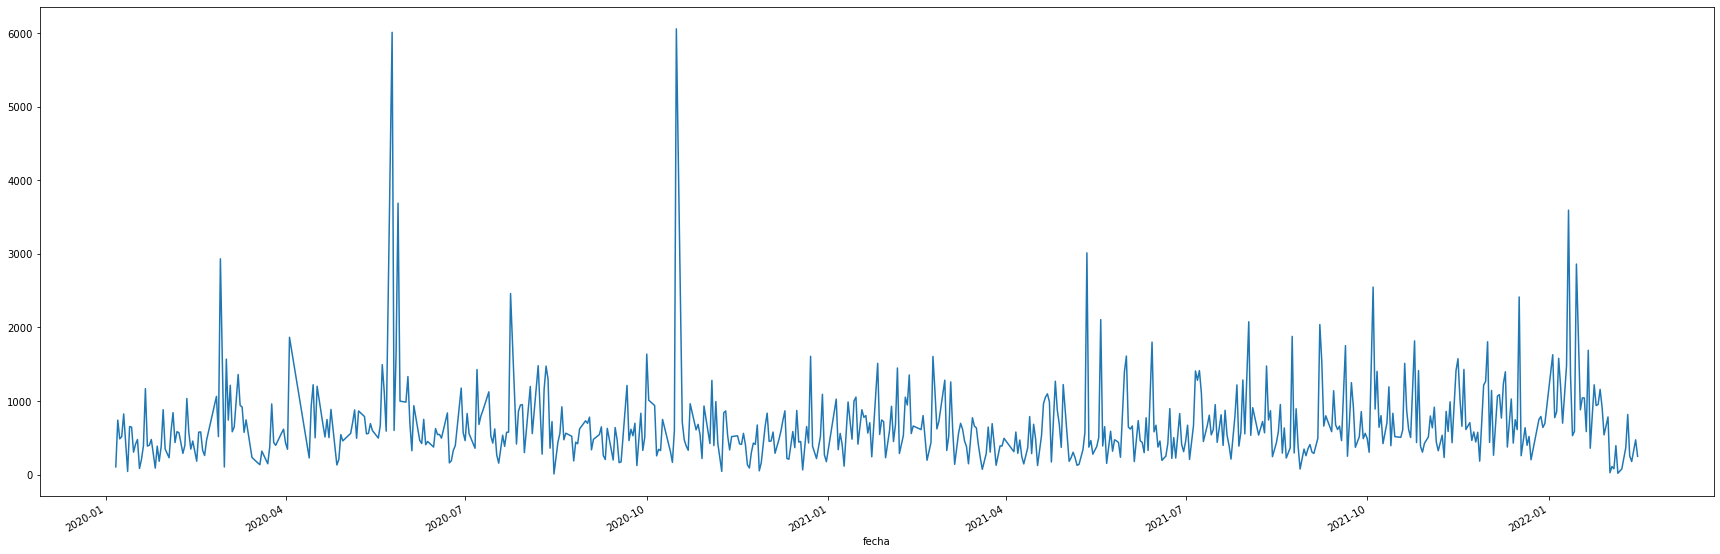

In [58]:
df_ventas_diarias = df_ventas_totales.groupby('fecha').monto_dolar.sum()
df_ventas_diarias.plot(figsize=(30,10))

In [59]:
df_ventas_totales.sort_values('monto_dolar', ascending=False).head(25)

,num,fecha_comp,cliente,vendedor,monto,tipo,cod,producto,cantidad,fecha,tasa_dolar,monto_dolar
10335,2020-0000004271-fa,2020-05-25 11:31:00,17527879,14,1.095920e+09,fa,00166,,0.0,2020-05-25,192730.620000,5686.278600
4329,2020-0000006335-fa,2020-10-16 08:31:00,14281701,10,1.321200e+09,fa,00507,,0.0,2020-10-16,443763.580000,2977.261000
4330,2020-0000006336-fa,2020-10-16 08:44:00,4094536,11,1.296000e+09,fa,00507,,0.0,2020-10-16,443763.580000,2920.474006
10466,2020-0000004402-fa,2020-05-28 00:00:00,310875820,13,5.273100e+08,fa,00180,,0.0,2020-05-28,189797.120000,2778.282410
18913,2021-0000000005-ne,2021-05-12 14:54:00,299674044.0,7,5.643000e+03,ne,00734,"MANGUERA TUBO PEAD 160MM/6"" PN10 (150PSI) GEMA...",132.0,2021-05-12,2.707692,2084.062475
151,2020-0000000005-ne,2020-02-28 14:57:00,10747486.0,7,1.500000e+08,ne,00005,,0.0,2020-02-28,72616.000000,2065.660461
1810,2020-0000000108-ne,2020-07-24 10:58:00,14281213.0,13,4.752000e+08,ne,00130,,0.0,2020-07-24,254549.150000,1866.830040
10400,2020-0000004336-fa,2020-05-27 10:20:00,21180074,7,2.425760e+08,fa,00167,,0.0,2020-05-27,191696.040000,1265.419985
13787,2022-0000006399-fa,2022-01-15 14:35:00,200007230.0,1,6.133500e+03,fa,04123,PINTURA CUÑETE BLANCO OSTRA,15.0,2022-01-15,4.900000,1251.734694
3989,2020-0000006292-fa,2020-10-01 12:29:00,9333194,10,4.896072e+08,fa,00500,,0.0,2020-10-01,428923.590000,1141.478936


## Almacenamiento del DF

In [60]:
%%time
# Guardamos el DF limpio para su análisis posterior

df_ventas_totales.to_parquet(f"{BASE_DIR / 'datos/out/ventas.parquet'}", 
                    compression='GZIP',
                    engine='pyarrow')

df_ventas_totales.to_csv(f"{BASE_DIR / 'datos/out/ventas.csv'}", sep=';')


# Guardamos el DF en un archivo Excel para utilizar los datos en Google Data Studio
df_ventas_totales.to_excel(f"{BASE_DIR / 'datos/out/ventas.xlsx'}", index = False)

CPU times: user 13.3 s, sys: 180 ms, total: 13.5 s
Wall time: 13.5 s


## Carga de Datos del Inventario

Datos sobre el inventario al final del período. Además incluye la clasificación de los productos en categorías.

Con esta información podemos determinar cuáles productos podrían entrar en rotura de stock en función de lo que se ha vendido y lo que queda en stock

In [61]:
FILE_STOCK = 'datos/in/*inv.xls'

df_stock = read_files(FILE_STOCK, 'fecha', 10)
df_stock

,Código,Descripción,Descrip linea/ validada,SActual,stock real 1,Ajuste(E/S),fecha
0,00001,PEGA DE CONTACTO/PEGA ZAPATERA (90 ML) ENVASADO,GENERALES,15.5,NaN,NaN,2022-02-16
1,00002,MANTO ASFALTICO 10MTSx3.2MM BITUPLAST,NO ASIGNADO,3.0,NaN,NaN,2022-02-16
2,00003,"TACO 1"" BASE REDONDA PVC DURA PARA PATAS DE MU...",GENERALES,13.0,NaN,NaN,2022-02-16
3,00004,MUEBLE ACCESORIOS DE BAÑO HIERRO FORJADO(UNIDAD),HIERRO FORJADO JC Y ABRAZADERAS METALICAS RIEGO,2.0,NaN,NaN,2022-02-16
4,00005,"NIPLE PLASTICO 1"" * 13CMS","NIPLES DE HIERRO GALVANIZADO, CROMADO Y PLASTICOS",14.0,NaN,NaN,2022-02-16
...,...,...,...,...,...,...,...
3602,06382,CONFITERIA CARAMELO CHAO X2,CHUCHERIAS,275.0,NaN,NaN,2022-02-16
3603,06383,CONFITERIA TRIDENT TOTAL YERBABUENA,CHUCHERIAS,4.0,NaN,NaN,2022-02-16
3604,06384,HIDROJET DE ALTA PRESION 1400W INGCO,GENERALES,1.0,NaN,NaN,2022-02-16
3605,06385,CONFITERIA SUSY MAXI 50GR,CHUCHERIAS,1.0,NaN,NaN,2022-02-16


### Limpieza del archivo de inventario

In [62]:
cols = ['cod', 'producto', 'linea', 'stock', 'stock2', 'ajuste', 'fecha']
df_stock.columns = cols
df_stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3607 entries, 0 to 3606
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   cod       3607 non-null   object 
 1   producto  3607 non-null   object 
 2   linea     3606 non-null   object 
 3   stock     3606 non-null   float64
 4   stock2    0 non-null      float64
 5   ajuste    0 non-null      float64
 6   fecha     3607 non-null   object 
dtypes: float64(3), object(4)
memory usage: 197.4+ KB


In [63]:
# Guardamos solo la información que nos interesa
df_stock = df_stock.loc[:,['cod', 'producto', 'linea', 'stock', 'fecha']]
df_stock

,cod,producto,linea,stock,fecha
0,00001,PEGA DE CONTACTO/PEGA ZAPATERA (90 ML) ENVASADO,GENERALES,15.5,2022-02-16
1,00002,MANTO ASFALTICO 10MTSx3.2MM BITUPLAST,NO ASIGNADO,3.0,2022-02-16
2,00003,"TACO 1"" BASE REDONDA PVC DURA PARA PATAS DE MU...",GENERALES,13.0,2022-02-16
3,00004,MUEBLE ACCESORIOS DE BAÑO HIERRO FORJADO(UNIDAD),HIERRO FORJADO JC Y ABRAZADERAS METALICAS RIEGO,2.0,2022-02-16
4,00005,"NIPLE PLASTICO 1"" * 13CMS","NIPLES DE HIERRO GALVANIZADO, CROMADO Y PLASTICOS",14.0,2022-02-16
...,...,...,...,...,...
3602,06382,CONFITERIA CARAMELO CHAO X2,CHUCHERIAS,275.0,2022-02-16
3603,06383,CONFITERIA TRIDENT TOTAL YERBABUENA,CHUCHERIAS,4.0,2022-02-16
3604,06384,HIDROJET DE ALTA PRESION 1400W INGCO,GENERALES,1.0,2022-02-16
3605,06385,CONFITERIA SUSY MAXI 50GR,CHUCHERIAS,1.0,2022-02-16


In [64]:
# Eliminamos las filas con NaN (total)
# Transformamos los tipos de columnas para que se guarden con
# el tipo correcto
df_stock.dropna(inplace=True)
df_stock.cod = df_stock.cod.astype(str)
df_stock.fecha = pd.to_datetime(df_stock.fecha)

df_stock.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3606 entries, 0 to 3605
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   cod       3606 non-null   object        
 1   producto  3606 non-null   object        
 2   linea     3606 non-null   object        
 3   stock     3606 non-null   float64       
 4   fecha     3606 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 169.0+ KB


In [65]:
%%time
# Guardamos el DF limpio para su análisis posterior

df_stock.to_parquet(f"{BASE_DIR / 'datos/out/stock.parquet'}", 
                    compression='GZIP',
                    engine='pyarrow')

df_stock.to_csv(f"{BASE_DIR / 'datos/out/stock.csv'}", sep=';')


# Guardamos el DF en un archivo Excel para utilizar los datos en Google Data Studio
df_stock.to_excel(f"{BASE_DIR / 'datos/out/stock.xlsx'}", index = False)


CPU times: user 574 ms, sys: 11.9 ms, total: 586 ms
Wall time: 593 ms
